# Check data from hubs


Testing more updates to the new firmware. This time with the newer batch of badges (47uF capacitors).

Batteries - Panasonic

New - 397,398,399
DB:97:55:CA:09:B2	397
F8:2D:A1:09:CC:CE	398
D4:9A:5C:60:CD:7A	399


Old - 400,401,402
E3:8B:2C:9D:CB:6C	400
F0:33:2C:A0:AE:DF	401
F0:02:47:00:FC:61	402


Two beacons:
F0:1F:64:C5:39:A3,176
E1:93:F4:62:28:B3,D

Starting - 10/29 10:10

Main changes:
New clock settings
Fixed proximity data pulling
faster send speed

On 10/31 1:36, D4:9A:5C:60:CD:7A got “stuck”. Do I’m restarting the hub to check if maybe something was holding the connection. Oops, restarted the wrong badge.

After that I’ve been running all kind of tests, so it might have affected the batteries and ata integrity

I started messing around with the badges on 11/02 13:25.. I also changed batteries in 398 and 399 and kept them running. And updated the firmware on 398. So ignore info after that part

I wiped and restarted this test only with 398 and 399 to check some stuff


In [1]:
#import sys
#!{sys.executable} -m pip install sklearn

In [3]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import pytz
import gzip

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [10]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '15S' # For proximity scans

folder = '../data/raw/20181029_test_firmware_v3_3/'
proximity_filename = folder+'proximity_archive.txt.gz'
audio_filename = folder+'audio_archive.txt.gz'
hublog_filename = folder+'hub.log.gz'

In [11]:
# enables the %%R magic, not necessary if you've already done this
import readline
%load_ext rpy2.ipython 

%R -i time_zone timezone <- time_zone; print(timezone)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


[1] "US/Eastern"


In [12]:
%%R
library(ggplot2)
library(scales)
rh_theme = theme(
    legend.title=element_text(size=2) , 
    legend.text=element_text(size=3)
    #panel.background=element_rect(fill="white"), # background=white
    #panel.grid.major.x=element_blank(), #no gridlines
    #panel.grid.minor.x=element_blank(), 
    #panel.grid.major.y=element_blank(), 
    #panel.grid.minor.y=element_blank(),
    #axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 4,face = "bold"),
    #axis.text.y = element_text(size = 4)
)

# Load data

In [7]:
print("Loading voltage data (from proximity records)")
with gzip.open(proximity_filename, 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone, skip_errors=True)

Loading voltage data (from proximity records)


In [8]:
print("Loading sample counts for proximity")
with gzip.open(proximity_filename, 'r') as f:
    proximity_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone, skip_errors=True)

print("Loading sample counts for audio")
with gzip.open(audio_filename, 'r') as f:
    audio_sample_counts = ob.preprocessing.sample_counts(f, tz=time_zone)


Loading sample counts for proximity
Loading sample counts for audio


In [66]:
print("Loading reset data")
with gzip.open(hublog_filename, 'r') as f:
    resets = ob.preprocessing.hublog_resets(f, log_tz = hublog_time_zone, tz=time_zone)

print("Loading clock sync data")
with gzip.open(hublog_filename, 'r') as f:
    clock_syncs = ob.preprocessing.hublog_clock_syncs(f, log_tz = hublog_time_zone, tz=time_zone)

Loading reset data
Loading clock sync data


In [14]:
# starting time
first_date = resets.index.get_level_values('datetime').min()
first_date

Timestamp('2018-10-29 10:13:13.885000-0400', tz='US/Eastern')

In [15]:
def to_relative_datetime(data):
    """ switch to relative time (since experiment started) """
    realtive_time = data.reset_index().copy()
    realtive_time['datetime'] = realtive_time['datetime'] - first_date
    realtive_time['day'] = realtive_time['datetime']/pd.Timedelta(days=1)
    return realtive_time

# Cleanup
Sometimes we get some records from the future or past. It's a bug, but it's so uncommon that we haven't found the reason yet


In [70]:
time_slice = slice('2018-10-01 00:00:00', '2018-11-02 13:00:00')

resets = resets.loc[time_slice, :]
voltages = voltages.loc[time_slice, :]

proximity_sample_counts.reset_index(level=1,inplace=True)
proximity_sample_counts = proximity_sample_counts.loc[time_slice, :]
proximity_sample_counts.set_index('member', append=True, inplace=True)

audio_sample_counts.reset_index(level=1,inplace=True)
audio_sample_counts = audio_sample_counts.loc[time_slice, :]
audio_sample_counts.set_index('member', append=True, inplace=True)

clock_syncs = clock_syncs.loc[time_slice, :]

# Split into two groups

In [18]:
members_full = pd.read_csv(folder+"Member-2018-11-02.csv")
members_full['type'] = members_full['id'].map(lambda x: 'a' if x < 4 else 'b')
members_full.head(10)

,key,date_created,date_updated,id,email,name,badge,observed_id,active,comments,last_audio_ts,last_audio_ts_fract,last_proximity_ts,last_contacted_ts,last_voltage,last_seen_ts,last_unsync_ts,project,type
0,0IDHT4GLUZ,2018-10-29 14:11:54,2018-11-02 17:45:18,6,NaN,402 (old),F0:02:47:00:FC:61,6,1,NaN,1.541181e+09,893.0,1.541181e+09,1.541181e+09,2.51,1.541181e+09,1.540822e+09,9,b
1,YUSSSTYE45,2018-10-29 14:11:54,2018-11-02 17:45:22,5,NaN,401 (old),F0:33:2C:A0:AE:DF,5,1,NaN,1.541181e+09,608.0,1.541181e+09,1.541181e+09,2.50,1.541181e+09,1.540822e+09,9,b
2,Z949RKUK1N,2018-10-29 14:11:54,2018-11-02 17:45:25,4,NaN,400 (old),E3:8B:2C:9D:CB:6C,4,1,NaN,1.541181e+09,642.0,1.541181e+09,1.541181e+09,2.51,1.541181e+09,1.540822e+09,9,b
3,QZPR05I3EC,2018-10-29 14:11:54,2018-11-02 17:45:07,3,NaN,399 (new),D4:9A:5C:60:CD:7A,3,1,NaN,1.541181e+09,753.0,1.541181e+09,1.541181e+09,2.96,1.541181e+09,1.541180e+09,9,a
4,XCUI4RPE9B,2018-10-29 14:11:54,2018-11-02 17:45:14,2,NaN,398 (new),F8:2D:A1:09:CC:CE,2,1,NaN,1.541181e+09,796.0,1.541181e+09,1.541181e+09,2.98,1.541181e+09,1.541002e+09,9,a
5,A2PILT8D6Z,2018-10-29 14:11:54,2018-11-02 17:45:10,1,NaN,397 (new),DB:97:55:CA:09:B2,1,1,NaN,1.541181e+09,320.0,1.541181e+09,1.541181e+09,2.53,1.541181e+09,1.540822e+09,9,a


# Voltage
Here we simply show the voltages of all the badges in the test. This helps us check how long they run and how fast the battery is deplated.

In [23]:
# Down sample
voltages_down = voltages.groupby([pd.TimeGrouper('300S', level='datetime'), 'member']).mean()

In [24]:
# Relative time
voltages_realtive_time = to_relative_datetime(voltages_down)

In [25]:
print(voltages_realtive_time.dtypes)
voltages_realtive_time.head()

datetime    timedelta64[ns]
member               object
voltage             float64
day                 float64
dtype: object


,datetime,member,voltage,day
0,-1 days +23:56:46.115000,0IDHT4GLUZ,3.186667,-0.002244
1,-1 days +23:56:46.115000,A2PILT8D6Z,0.000000,-0.002244
2,-1 days +23:56:46.115000,QZPR05I3EC,0.000000,-0.002244
3,-1 days +23:56:46.115000,XCUI4RPE9B,0.000000,-0.002244
4,-1 days +23:56:46.115000,YUSSSTYE45,3.187143,-0.002244


In [26]:
voltages_realtive_time = voltages_realtive_time.join(members_full.set_index('key')[['type']], on='member')
voltages_realtive_time.head(5)

,datetime,member,voltage,day,type
0,-1 days +23:56:46.115000,0IDHT4GLUZ,3.186667,-0.002244,b
1,-1 days +23:56:46.115000,A2PILT8D6Z,0.000000,-0.002244,a
2,-1 days +23:56:46.115000,QZPR05I3EC,0.000000,-0.002244,a
3,-1 days +23:56:46.115000,XCUI4RPE9B,0.000000,-0.002244,a
4,-1 days +23:56:46.115000,YUSSSTYE45,3.187143,-0.002244,b


In [27]:
a_only = voltages_realtive_time.query('type == "a"')
b_only = voltages_realtive_time.query('type == "b"')

/home/orenled/.virtualenvs/openbadge-analysis-test-badge/local/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "datetime". Fall back to string conversion. The error is: Unknown numpy array type 'timedelta64[ns]'.
  (name, str(e)))


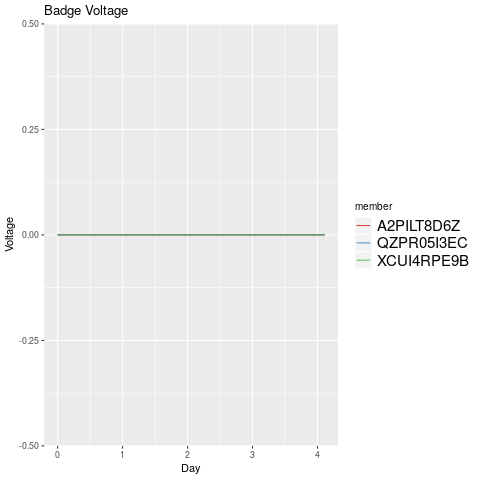

In [28]:
%%R -i a_only
data <- a_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.4) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(
        legend.title=element_text(size=10) ,
        legend.text=element_text(size=15)
        ) 

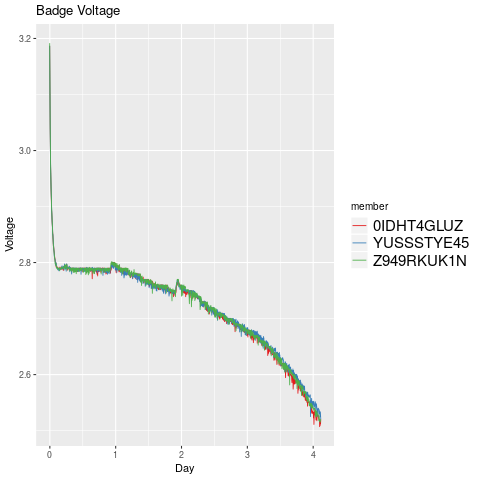

In [29]:
%%R -i b_only
data <- b_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.4) +
    labs(title="Badge Voltage", x="Day", y="Voltage") +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(
        legend.title=element_text(size=10) ,
        legend.text=element_text(size=15)
        )

# Resets
Here we look at "reset events" - when the hub sends the date the a badge, and the badge did not have a date set already. This means that the badge was either just turned on, or was reset. We expect to see a reset when the badge was first turned on, and we don't expect to see any resest until the voltages drop below 2.4v or so

In [30]:
resets_down = resets.copy()
resets_down['cnt'] = 1
resets_down = resets_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac']).count()
resets_down.head(1)

,,cnt
datetime,mac,
2018-10-29 10:00:00-04:00,D4:9A:5C:60:CD:7A,1


In [31]:
# switch to relative time (since experiment started)
resets_realtive_time = to_relative_datetime(resets_down)
resets_realtive_time.head()

,datetime,mac,cnt,day
0,-1 days +23:46:46.115000,D4:9A:5C:60:CD:7A,1,-0.009188
1,-1 days +23:46:46.115000,DB:97:55:CA:09:B2,1,-0.009188
2,-1 days +23:46:46.115000,E1:93:F4:62:28:B3,1,-0.009188
3,-1 days +23:46:46.115000,E3:8B:2C:9D:CB:6C,1,-0.009188
4,-1 days +23:46:46.115000,F0:02:47:00:FC:61,1,-0.009188


In [32]:
#resets_realtive_time = resets_realtive_time.join(mac_to_key_with_type.set_index('mac'), on='mac')
resets_realtive_time = resets_realtive_time.join(members_full.set_index('badge')[['type']], on='mac')

In [33]:
resets_realtive_time_a_only = resets_realtive_time.query('type == "a"')
resets_realtive_time_b_only = resets_realtive_time.query('type == "b"')

In [34]:
resets_realtive_time_a_only

,datetime,mac,cnt,day,type
0,-1 days +23:46:46.115000,D4:9A:5C:60:CD:7A,1,-0.009188,a
1,-1 days +23:46:46.115000,DB:97:55:CA:09:B2,1,-0.009188,a
7,-1 days +23:46:46.115000,F8:2D:A1:09:CC:CE,1,-0.009188,a
8,2 days 01:46:46.115000,D4:9A:5C:60:CD:7A,1,2.074145,a
9,2 days 01:46:46.115000,F8:2D:A1:09:CC:CE,1,2.074145,a
10,2 days 02:16:46.115000,D4:9A:5C:60:CD:7A,1,2.094978,a
11,3 days 17:46:46.115000,D4:9A:5C:60:CD:7A,2,3.740812,a
12,3 days 18:16:46.115000,D4:9A:5C:60:CD:7A,1,3.761645,a
13,3 days 18:46:46.115000,D4:9A:5C:60:CD:7A,3,3.782478,a
14,3 days 19:16:46.115000,D4:9A:5C:60:CD:7A,4,3.803312,a


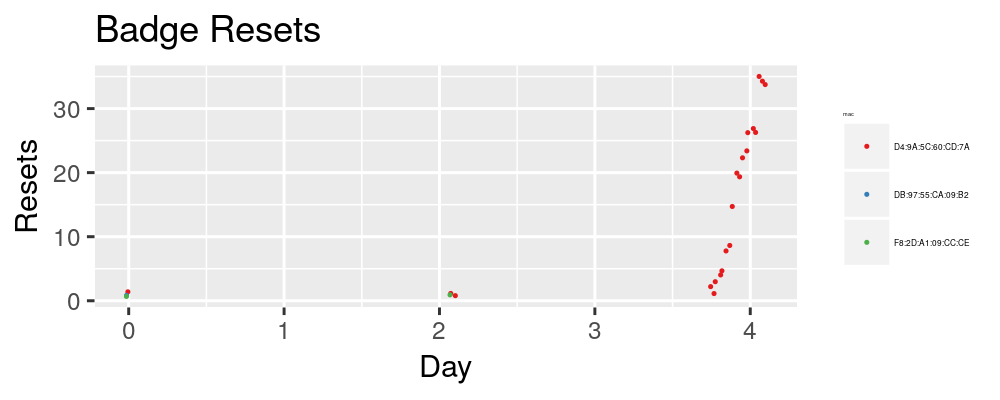

In [35]:
%%R -i resets_realtive_time_a_only -w 5 -h 2 --units in -r 200
data <- resets_realtive_time_a_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge Resets", x="Day", y="Resets") +
    rh_theme +
    scale_colour_brewer(palette = "Set1")
    #theme(legend.position="none")

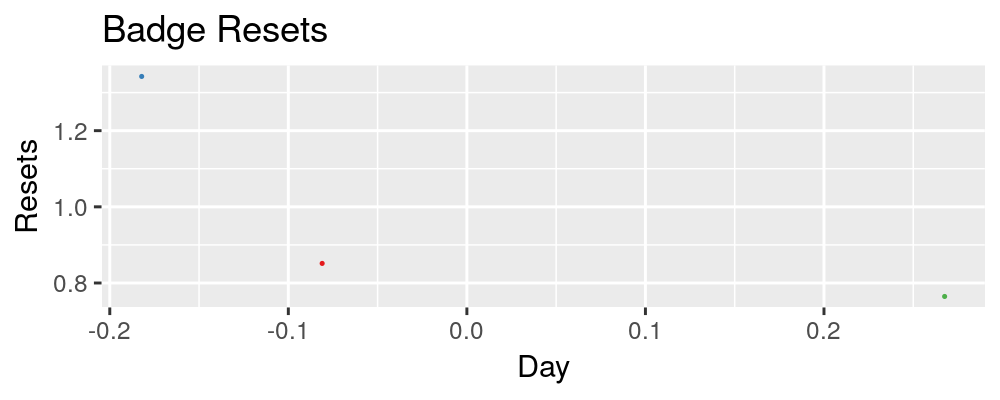

In [36]:
%%R -i resets_realtive_time_b_only -w 5 -h 2 --units in -r 200
data <- resets_realtive_time_b_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge Resets", x="Day", y="Resets") +
    rh_theme +
    scale_colour_brewer(palette = "Set1") +
    theme(legend.position="none")

# First resets
The first time a badge was reset (after starting)

In [37]:
df = pd.DataFrame([[1, np.nan], [1, 4], [5, 6]], columns=['A', 'B'])
g = df.groupby('A').nth(0)
df

,A,B
0,1,NaN
1,1,4.0
2,5,6.0


In [38]:
first_reset = resets.copy().reset_index()
first_reset = first_reset.groupby('mac').nth(1) # second reset. #0 is the first "reset" which is actually the first time the badge got a date from the server

In [39]:
first_reset.head(5)

,datetime
mac,
D4:9A:5C:60:CD:7A,2018-10-31 12:14:28.913000-04:00
F8:2D:A1:09:CC:CE,2018-10-31 12:06:22.649000-04:00


In [40]:
# switch to relative time (since experiment started)
first_reset_realtive_time = to_relative_datetime(first_reset)
first_reset_realtive_time.head()

,mac,datetime,day
0,D4:9A:5C:60:CD:7A,2 days 02:01:15.028000,2.084202
1,F8:2D:A1:09:CC:CE,2 days 01:53:08.764000,2.078574


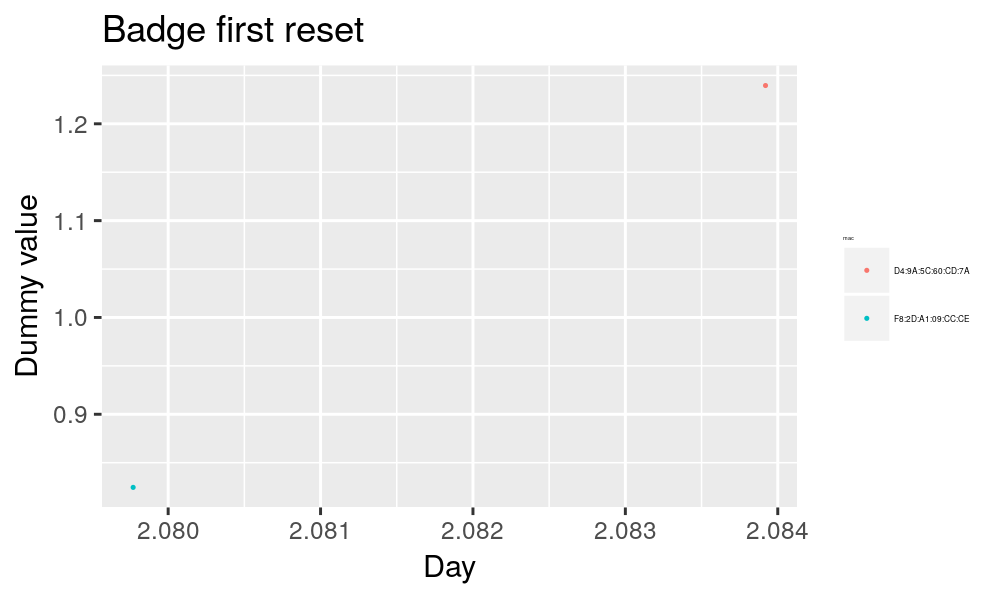

In [41]:
%%R -i first_reset_realtive_time -w 5 -h 3 --units in -r 200
data <- first_reset_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = 1, color = mac)) +
    geom_point(size=0.2, position = "jitter") +
    labs(title="Badge first reset", x="Day", y="Dummy value") +
    rh_theme 
    #theme(legend.position="none")

# Proximity sample counts

In [42]:
# Down sample
proximity_sample_counts_down = proximity_sample_counts.copy()
proximity_sample_counts_down = proximity_sample_counts_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).mean()
proximity_sample_counts_down.head(1)

# switch to relative time (since experiment started)
proximity_sample_counts_realtive_time = to_relative_datetime(proximity_sample_counts_down)
proximity_sample_counts_realtive_time.head()

,datetime,member,cnt,day
0,-1 days +23:46:46.115000,0IDHT4GLUZ,6.878788,-0.009188
1,-1 days +23:46:46.115000,A2PILT8D6Z,6.907692,-0.009188
2,-1 days +23:46:46.115000,QZPR05I3EC,6.818182,-0.009188
3,-1 days +23:46:46.115000,XCUI4RPE9B,6.742424,-0.009188
4,-1 days +23:46:46.115000,YUSSSTYE45,6.805970,-0.009188


In [43]:
proximity_sample_counts_realtive_time = proximity_sample_counts_realtive_time.join(members_full.set_index('key')[['type']], on='member')

In [44]:
proximity_sample_counts_realtive_time_a_only = proximity_sample_counts_realtive_time.query('type == "a"')
proximity_sample_counts_realtive_time_b_only = proximity_sample_counts_realtive_time.query('type == "b"')

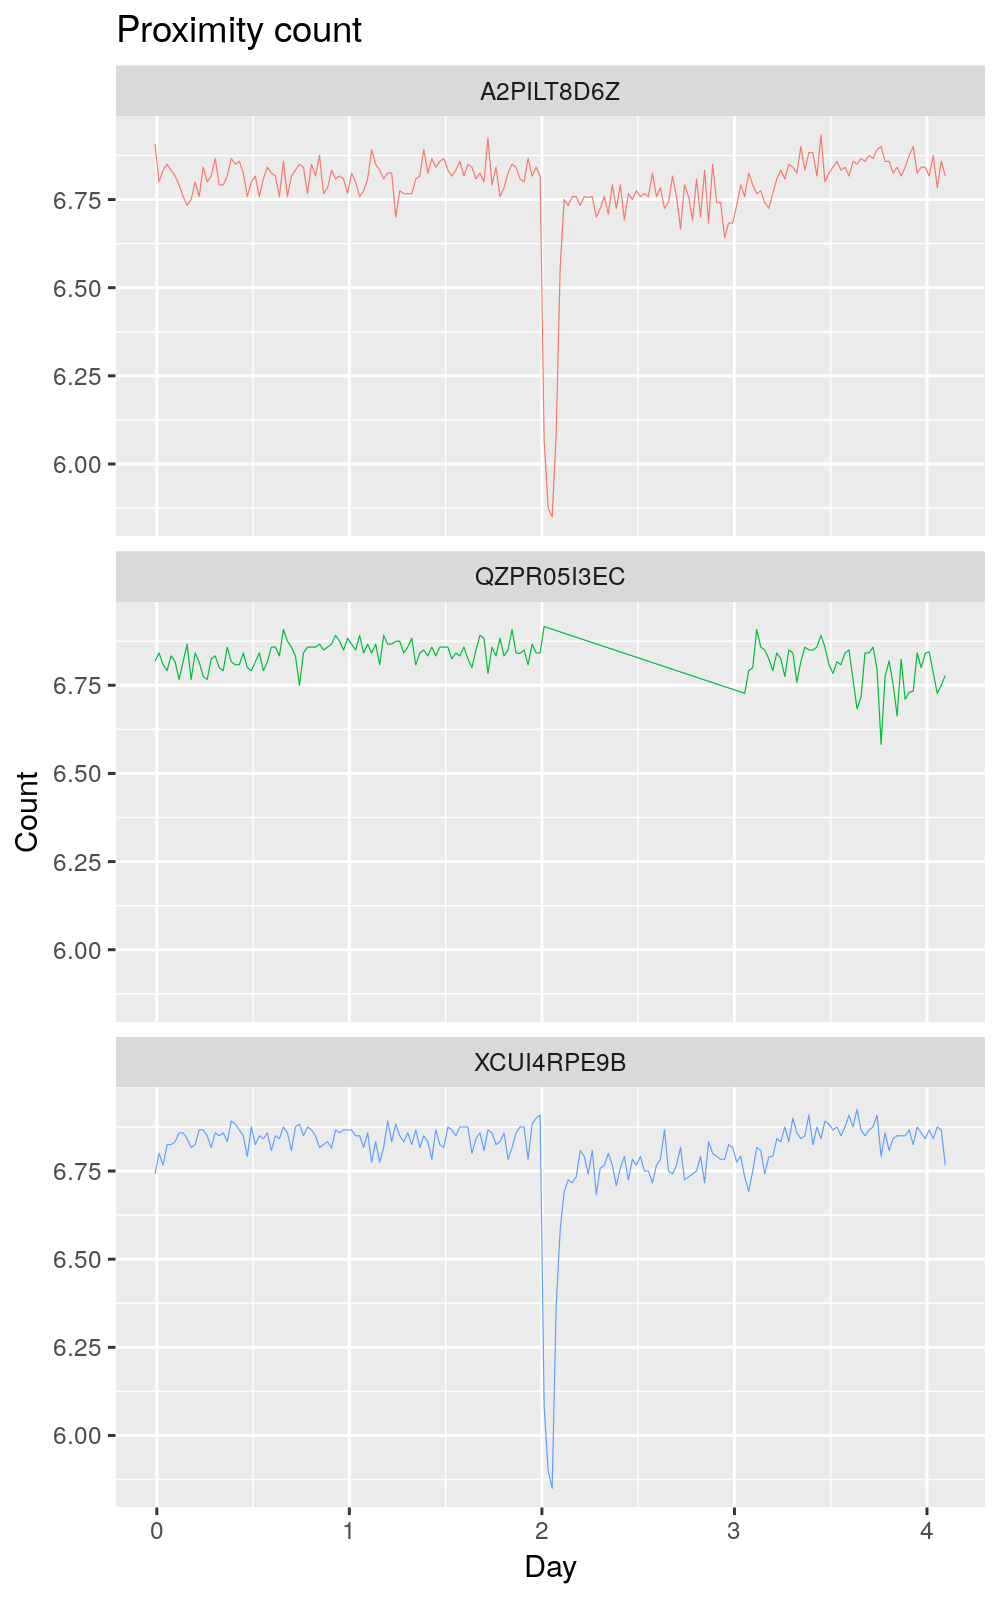

In [45]:
%%R -i proximity_sample_counts_realtive_time_a_only -w 5 -h 8 --units in -r 200
data <- proximity_sample_counts_realtive_time_a_only
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = cnt, color =member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Proximity count", x="Day", y="Count") +
    rh_theme +
    theme(legend.position="none")

# Audio records count
For audio, we can't simply down sample. At least for the current version, we might get a "partial" record (less than 114 samples), and later the full version of the record. We'll therefore remove the duplications (using group by), and then resample and fill NaN with zeros in order to find gaps. We use a 10S window since every record represents 5.7 seconds of data, and we want to make sure not to create zero counts when there is no need to.

In [46]:
audio_sample_counts_down = audio_sample_counts.copy()

In [47]:
# Removing records so I can test what happens when there is missing data
#s = slice('2017-12-02 16:55:20', '2017-12-02 16:55:40')
#audio_sample_counts_down.drop(audio_sample_counts_down.loc[(s, slice(None), slice(None)), :].index, inplace=True)
#print(len(audio_sample_counts))
#print(len(audio_sample_counts_down))

In [48]:
# If there are duplicates, choose the record with the most samples (that's a complete record)
audio_sample_counts_down = audio_sample_counts_down.groupby(['datetime', 'member']).max()

# Put 0's if there is missing data
audio_sample_counts_down = audio_sample_counts_down.unstack(level=[1]).resample('10S').min().fillna(0).stack(level=[1])

In [49]:
# If removed records for testing, are there 0's there now?
#audio_counts_down.loc[(s, slice(None), slice(None)), :]

In [50]:
# Down sample
audio_sample_counts_down = audio_sample_counts_down.unstack(level=[1]).resample('1min').min().stack(level=[1])
audio_sample_counts_realtive_time = audio_sample_counts_down.reset_index()

In [51]:
audio_sample_counts_realtive_time = audio_sample_counts_realtive_time.join(members_full.set_index('key')[['type']], on='member')

In [52]:
audio_sample_counts_realtive_time_a_only = audio_sample_counts_realtive_time.query('type == "a"')
audio_sample_counts_realtive_time_b_only = audio_sample_counts_realtive_time.query('type == "b"')

/home/orenled/.virtualenvs/openbadge-analysis-test-badge/local/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "datetime". Fall back to string conversion. The error is: Cannot pass numpy arrays with non-native byte orders at the moment.
  (name, str(e)))


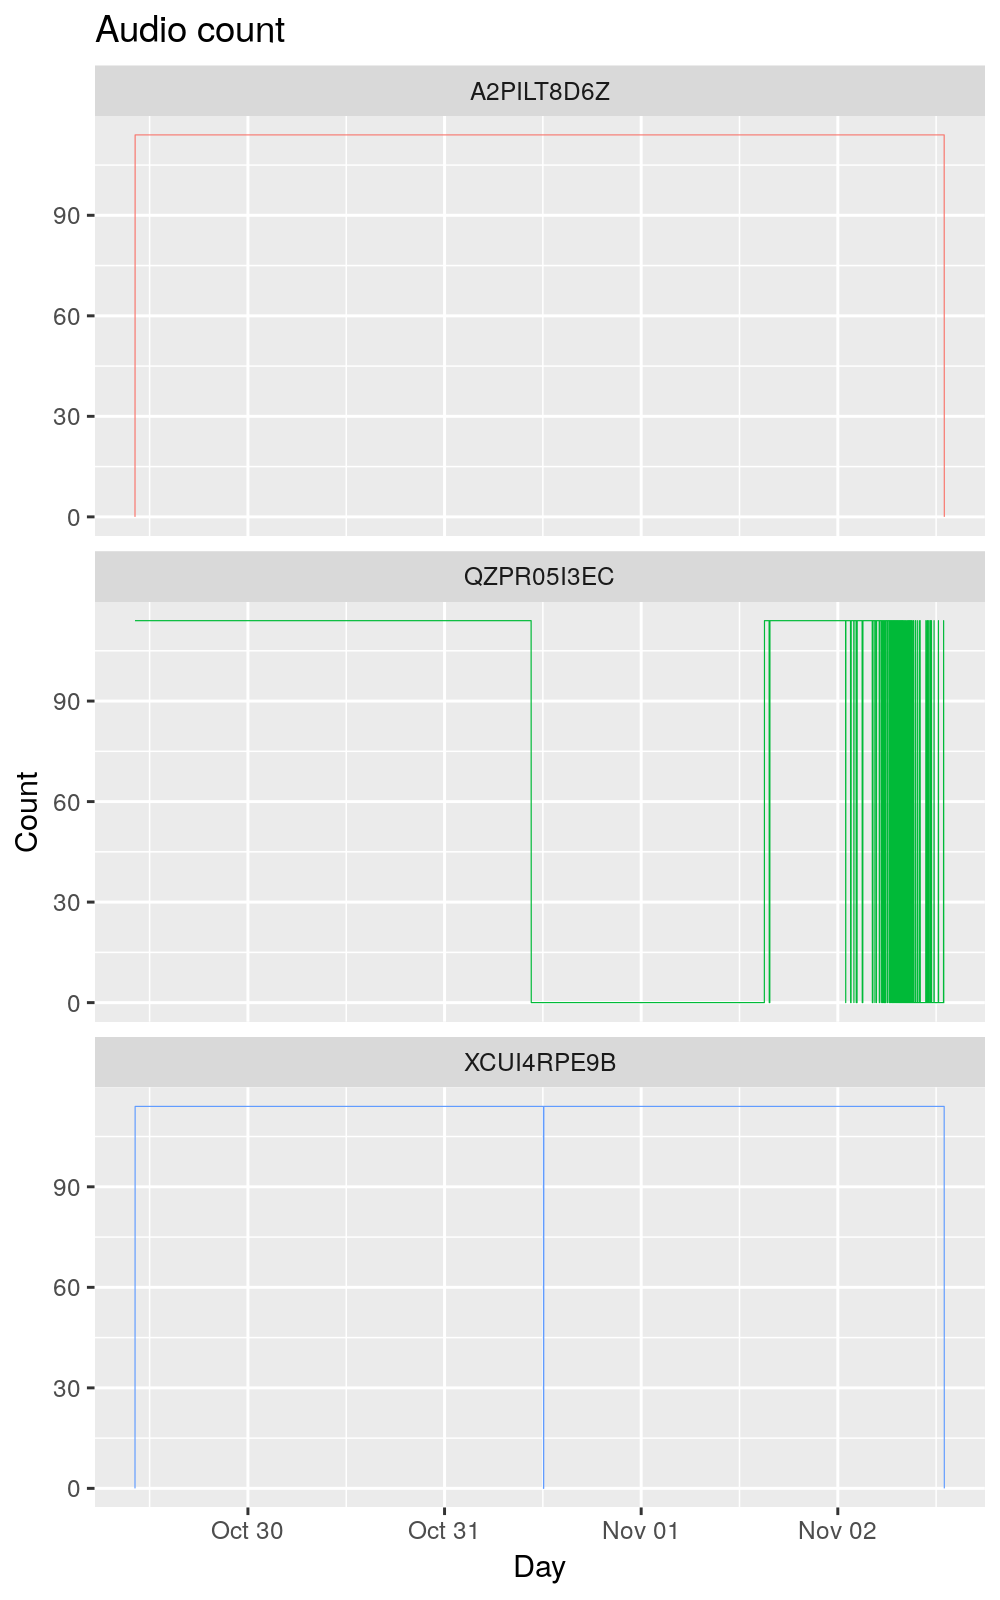

In [53]:
%%R -i audio_sample_counts_realtive_time_a_only -w 5 -h 8 --units in -r 200
data <- audio_sample_counts_realtive_time_a_only
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = cnt, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Audio count", x="Day", y="Count") +
    rh_theme +
    theme(legend.position="none")

# Gaps in proximity data
Here we look for gaps in proximity data. We expect to see gaps of 60 seconds between scans (or less/more, depending on the settings used). If it's higher than that, then there's a gap.

In [54]:
proximity_sample_counts_shift = proximity_sample_counts.copy().reset_index()
proximity_sample_counts_shift['lag_datetime'] = proximity_sample_counts_shift.groupby(['member'])['datetime'].shift(1)
proximity_sample_counts_shift['lag_datetime'] = proximity_sample_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
proximity_sample_counts_shift['time_diff_sec']= (proximity_sample_counts_shift['datetime']-proximity_sample_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

# Down sample
proximity_sample_counts_shift.set_index('datetime', inplace=True)
proximity_sample_counts_shift_down = proximity_sample_counts_shift.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).max()

# switch to relative time (since experiment started)
proximity_sample_counts_shift_realtive_time = to_relative_datetime(proximity_sample_counts_shift_down)
proximity_sample_counts_shift_realtive_time.head()

,datetime,member,cnt,lag_datetime,time_diff_sec,day
0,-1 days +23:46:46.115000,0IDHT4GLUZ,7,2018-10-29 10:29:42-04:00,15.0,-0.009188
1,-1 days +23:46:46.115000,A2PILT8D6Z,7,2018-10-29 10:29:30-04:00,15.0,-0.009188
2,-1 days +23:46:46.115000,QZPR05I3EC,7,2018-10-29 10:29:32-04:00,15.0,-0.009188
3,-1 days +23:46:46.115000,XCUI4RPE9B,7,2018-10-29 10:29:39-04:00,15.0,-0.009188
4,-1 days +23:46:46.115000,YUSSSTYE45,7,2018-10-29 10:29:43-04:00,15.0,-0.009188


/home/orenled/.virtualenvs/openbadge-analysis-test-badge/local/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "lag_datetime". Fall back to string conversion. The error is: Cannot pass numpy arrays with non-native byte orders at the moment.
  (name, str(e)))


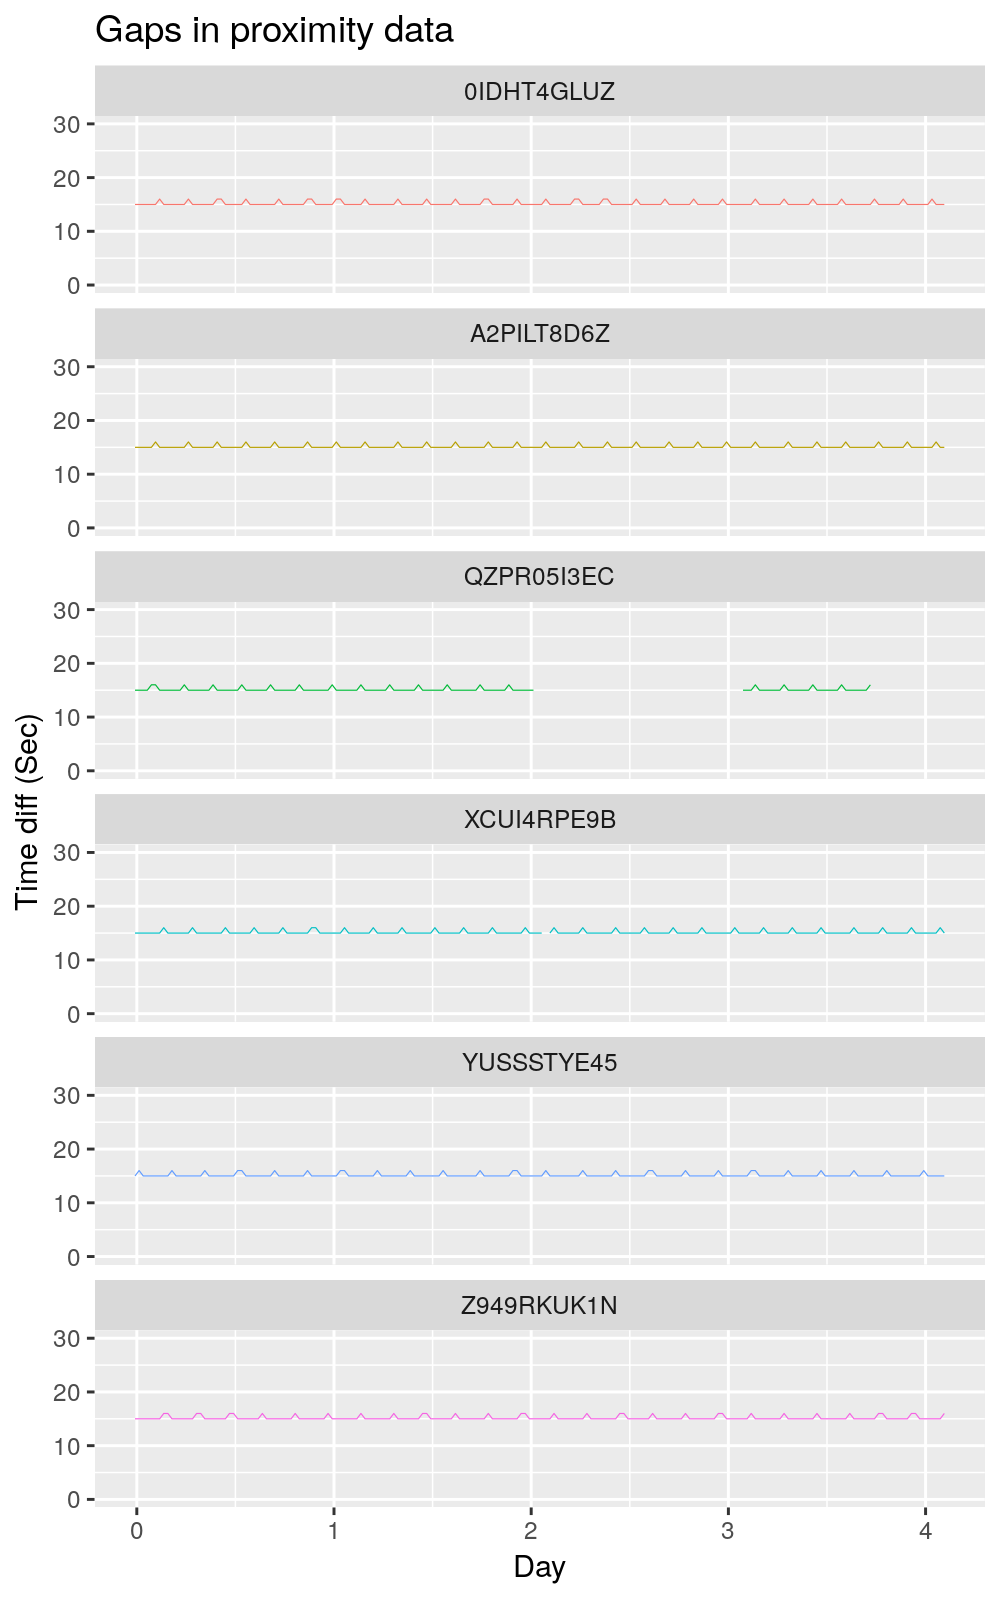

In [55]:
%%R -i proximity_sample_counts_shift_realtive_time -w 5 -h 8 --units in -r 200
data <- proximity_sample_counts_shift_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    labs(title="Gaps in proximity data", x="Day", y="Time diff (Sec)") +
    #scale_y_continuous(limits = c(0, 100)) +
    ylim(0, 30)+
    rh_theme +
    theme(legend.position="none")

# Gaps in audio data
Here we look for gaps in audio data. We expect to see gaps of 5.7 seconds between records (each record represents 114 samples of 50 ms each). If it's higher than that, then there's a gap.

In [56]:
audio_sample_counts.reset_index(inplace = True)
audio_sample_counts = audio_sample_counts[audio_sample_counts['datetime']> first_date]
audio_sample_counts.set_index(['datetime','member'], inplace = True)

In [57]:
audio_sample_counts_shift = audio_sample_counts.copy().reset_index()
audio_sample_counts_shift['lag_datetime'] = audio_sample_counts_shift.groupby(['member'])['datetime'].shift(1)
audio_sample_counts_shift['lag_datetime'] = audio_sample_counts_shift['lag_datetime'].dt.tz_localize('UTC').dt.tz_convert(time_zone)
audio_sample_counts_shift['time_diff_sec']= (audio_sample_counts_shift['datetime']-audio_sample_counts_shift['lag_datetime']) / np.timedelta64(1, 's')

# Down sample
audio_sample_counts_shift.set_index('datetime', inplace=True)
audio_sample_counts_shift_down = audio_sample_counts_shift.groupby([pd.TimeGrouper('30min', level='datetime'), 'member']).max()

# switch to relative time (since experiment started)
audio_sample_counts_shift_realtive_time = to_relative_datetime(audio_sample_counts_shift_down)
audio_sample_counts_shift_realtive_time.head()

,datetime,member,cnt,lag_datetime,time_diff_sec,day
0,-1 days +23:46:46.115000,0IDHT4GLUZ,114,2018-10-29 10:29:53.100000-04:00,5.704,-0.009188
1,-1 days +23:46:46.115000,A2PILT8D6Z,114,2018-10-29 10:29:50.467000-04:00,5.702,-0.009188
2,-1 days +23:46:46.115000,QZPR05I3EC,114,2018-10-29 10:29:48.976000-04:00,5.700,-0.009188
3,-1 days +23:46:46.115000,XCUI4RPE9B,114,2018-10-29 10:29:49.912000-04:00,5.700,-0.009188
4,-1 days +23:46:46.115000,YUSSSTYE45,114,2018-10-29 10:29:51.210000-04:00,5.807,-0.009188


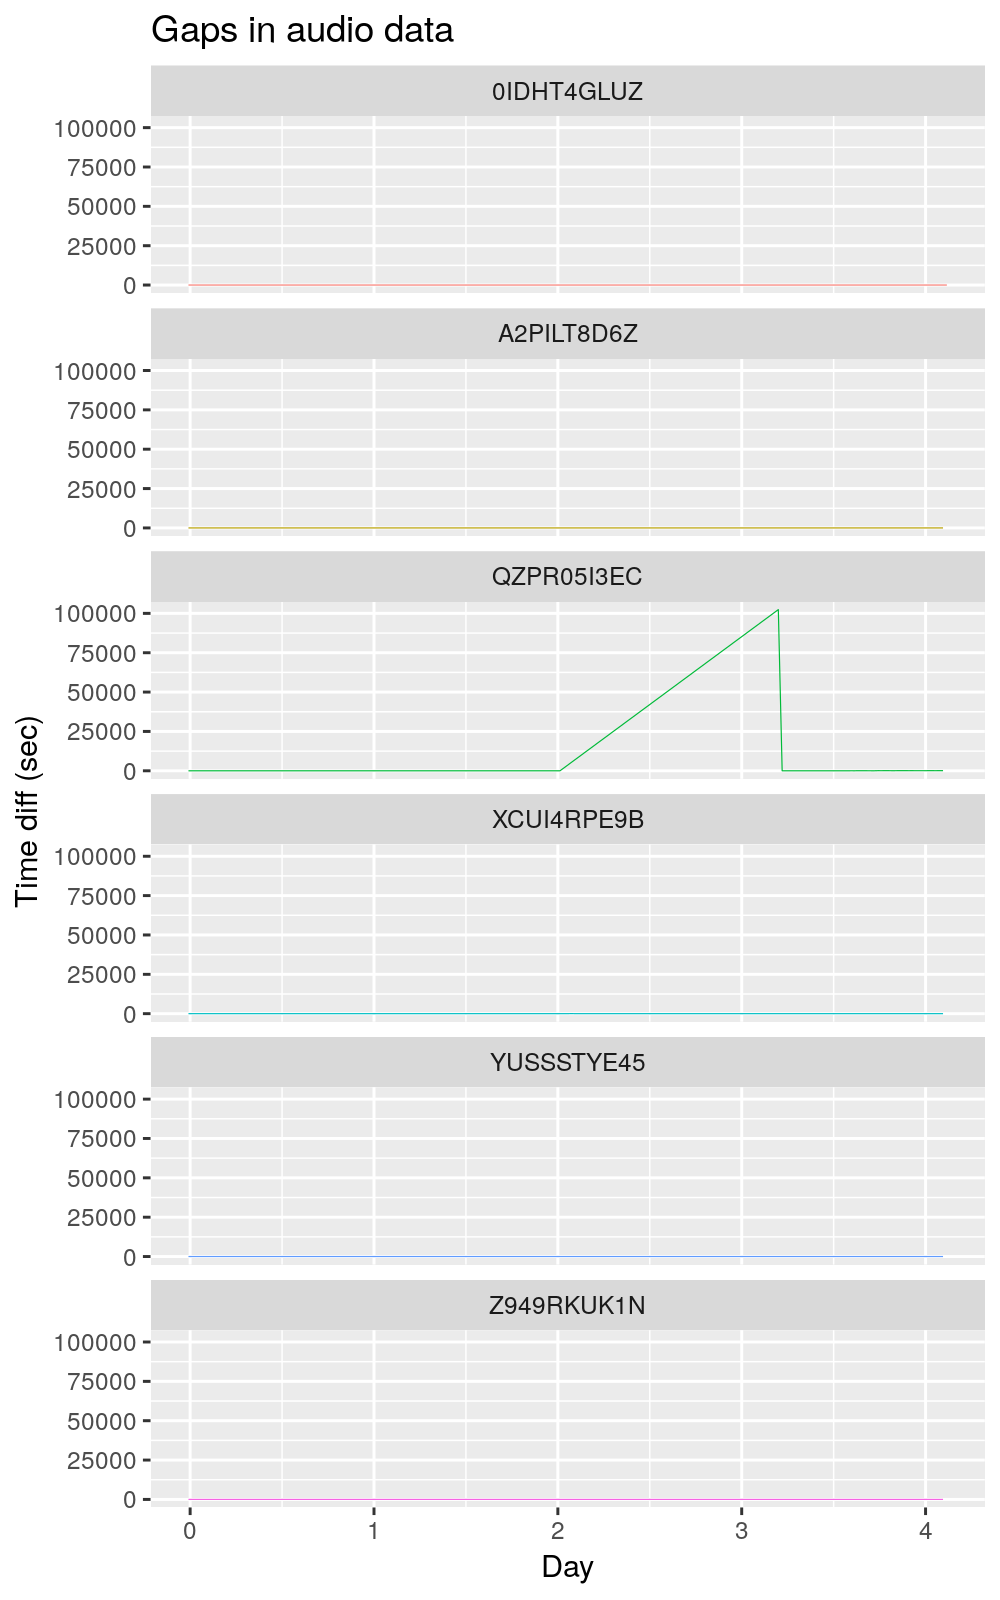

In [58]:
%%R -i audio_sample_counts_shift_realtive_time -w 5 -h 8 --units in -r 200
data <- audio_sample_counts_shift_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = time_diff_sec, color = member)) +
    geom_line(size=0.2) +
    facet_wrap( ~ member, ncol=1)+
    #scale_y_continuous(limits = c(0, 100)) +
    labs(title="Gaps in audio data", x="Day", y="Time diff (sec)") +
    rh_theme +
    theme(legend.position="none")

# Comparing badge time to hub time
Here, we look at event where we send time from the hub to the badge. On each event, the badge reports back its internal time

In [84]:
clock_syncs_down = clock_syncs.copy().reset_index()
clock_syncs_down['clock_diff']=(clock_syncs_down['datetime']-clock_syncs_down['badge_datetime'])/pd.Timedelta(milliseconds=1)

clock_syncs_down.set_index(['datetime','mac'], inplace=True)
clock_syncs_down = clock_syncs_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac'])['clock_diff'].max().to_frame()

clock_syncs_down.reset_index(inplace=True)
clock_syncs_down = clock_syncs_down.join(members_full.set_index('badge')[['type']], on='mac')
clock_syncs_down.head(20)

,datetime,mac,clock_diff,type
0,2018-10-29 10:00:00-04:00,D4:9A:5C:60:CD:7A,1.540822e+12,a
1,2018-10-29 10:00:00-04:00,DB:97:55:CA:09:B2,1.540822e+12,a
2,2018-10-29 10:00:00-04:00,E1:93:F4:62:28:B3,1.540822e+12,NaN
3,2018-10-29 10:00:00-04:00,E3:8B:2C:9D:CB:6C,1.540822e+12,b
4,2018-10-29 10:00:00-04:00,F0:02:47:00:FC:61,1.540822e+12,b
5,2018-10-29 10:00:00-04:00,F0:1F:64:C5:39:A3,1.540822e+12,NaN
6,2018-10-29 10:00:00-04:00,F0:33:2C:A0:AE:DF,1.540822e+12,b
7,2018-10-29 10:00:00-04:00,F8:2D:A1:09:CC:CE,1.540822e+12,a
8,2018-10-29 10:30:00-04:00,D4:9A:5C:60:CD:7A,1.530000e+02,a
9,2018-10-29 10:30:00-04:00,DB:97:55:CA:09:B2,1.730000e+02,a


In [107]:
# Down sample
clock_syncs_down = clock_syncs.copy().reset_index()
clock_syncs_down['clock_diff']=(clock_syncs_down['datetime']-clock_syncs_down['badge_datetime'])/pd.Timedelta(milliseconds=1)

clock_syncs_down.set_index(['datetime','mac'], inplace=True)
clock_syncs_down = clock_syncs_down.groupby([pd.TimeGrouper('30min', level='datetime'), 'mac'])['clock_diff'].mean().to_frame()
clock_syncs_down.reset_index(inplace=True)
clock_syncs_down = clock_syncs_down.join(members_full.set_index('badge')[['type']], on='mac')
clock_syncs_down['mac_and_type'] = clock_syncs_down['type'] + " " + clock_syncs_down['mac']
clock_syncs_down = clock_syncs_down.dropna() # removed beacons (we extract them from the logs...)

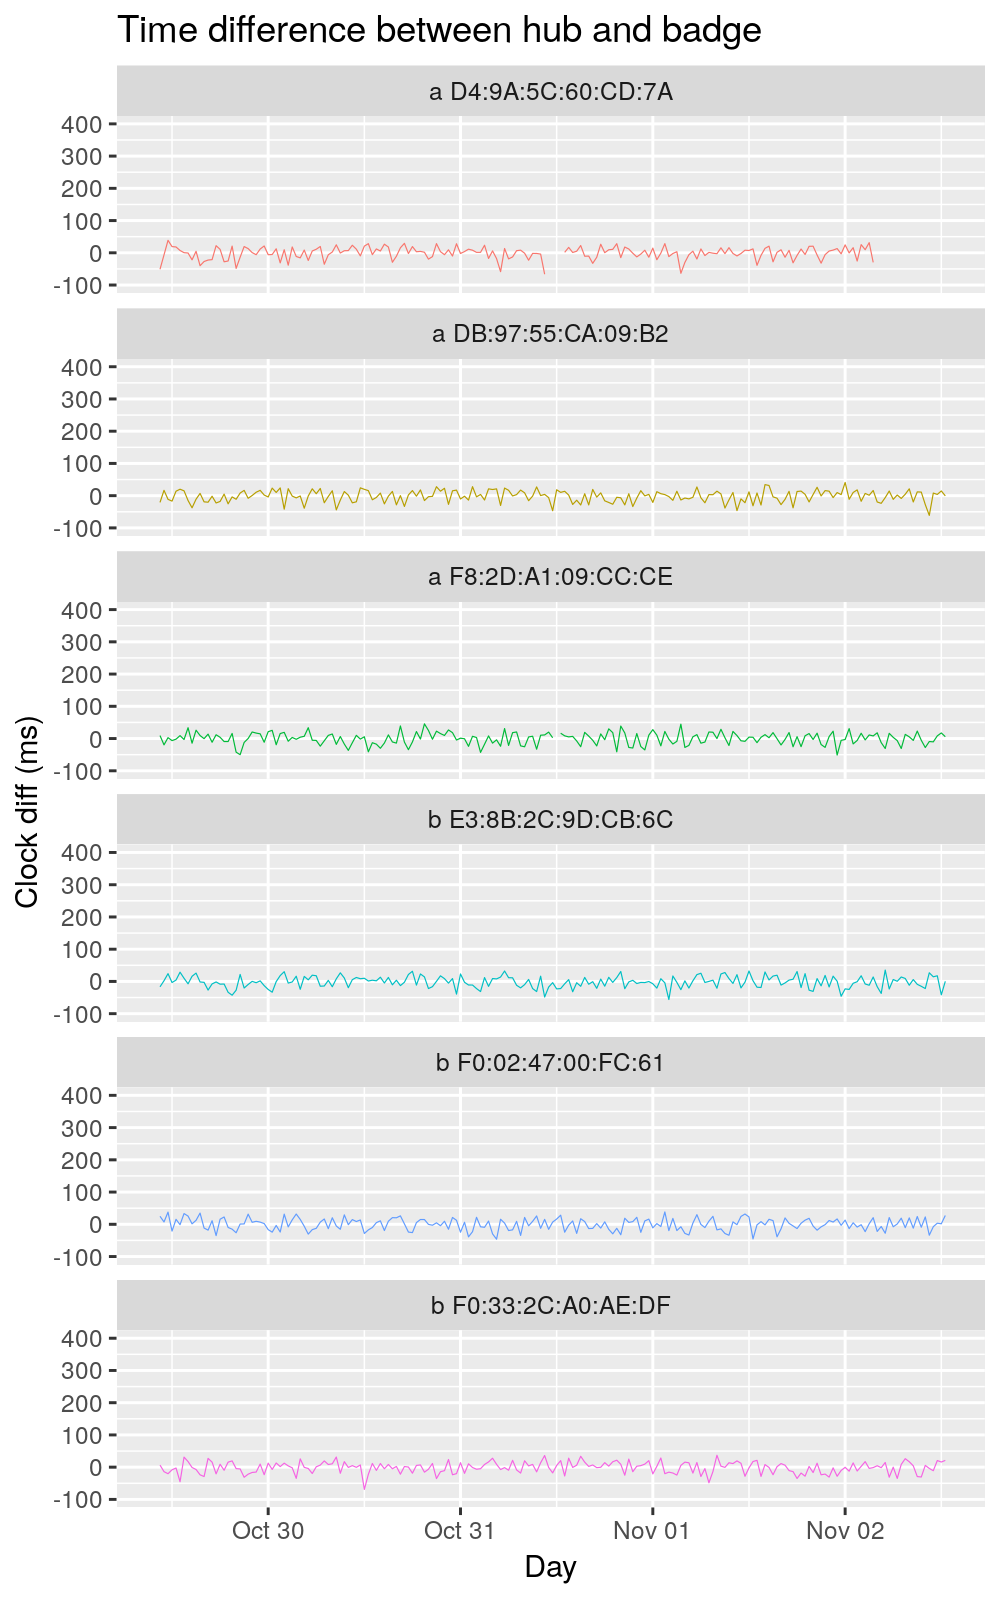

In [108]:
%%R -i clock_syncs_down -w 5 -h 8 --units in -r 200
data <- clock_syncs_down
data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = datetime, y = clock_diff, color = mac_and_type)) +
    geom_line(size=0.2) +
    facet_wrap( ~ mac_and_type, ncol=1)+
    labs(title="Time difference between hub and badge", x="Day", y="Clock diff (ms)") +
    rh_theme +
    theme(legend.position="none") +
    ylim(-100, 400)
